## Import Packages

In [66]:
!pip install meteocalc==1.1.0
!pip install lightgbm==2.3.1

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

DATA_PATH = "./"

## Load Data

## Utility Functions

In [68]:
# https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type?scriptVersionId=22831732

weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}


RAW_DATA_DIR = './'
weather_train = pd.read_csv('weather_train.csv',dtype=weather_dtypes, parse_dates=['timestamp'])
weather_test = pd.read_csv('weather_test.csv',dtype=weather_dtypes, parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather

data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (pd.to_datetime(df["timestamp"]) - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [69]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like

def c2f(T):
    return T * 9 / 5. + 32

def windchill(T, v):
    return (10*v**.5 - v +10.5) * (33 - T)

def prepareweather(df):
    df['RH'] = 100 - 5 * (df['air_temperature']-df['dew_temperature'])
#     df['RH_above50'] = (df['RH'] > 50).astype(int) 
    df['heat'] = df.apply(lambda x: heat_index(c2f(x.air_temperature), x.RH).c, axis=1)
    df['windchill'] = df.apply(lambda x: windchill(x.air_temperature, x.wind_speed), axis=1)
    df['feellike'] = df.apply(lambda x: feels_like(c2f(x.air_temperature), x.RH, x.wind_speed*2.237).c, axis=1)
    
    return df



def add_lag_feature(weather_df, window=3):  
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'dew_temperature', 'heat', 'windchill', 'feellike']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
#         weather_df[f'{col}_max_lag{window}'] = lag_max[col]
#         weather_df[f'{col}_min_lag{window}'] = lag_min[col]
#         weather_df[f'{col}_std_lag{window}'] = lag_std[col]


def fill_weather_dataset(weather_df):
    
    
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True) 
        
#     for col in weather_df.columns:
#         if col != 'timestamp':
#             if weather_df[col].isna().sum():
#                 weather_df['na_'+col] = weather_df[col].isna().astype(int)

#     weather_df['weath_na_total'] = weather_df.isna().sum(axis=1)
    
    weather_df = timestamp_align(weather_df)
    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
    
    
    

    
    print('add heat, RH...')
    weather_df = prepareweather(weather_df)
    
    print('add lag features')
    add_lag_feature(weather_df, window=3)
    
    return weather_df




# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed", "precip_depth_1_hr"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    return df


def building_features(building_meta_df):
    building_addfeatures = pd.read_feather('building_all_meters.feather')
    
    for col in building_meta_df.columns:
        if col != 'timestamp':
            if building_meta_df[col].isna().sum():
                building_meta_df['na_'+col] = building_meta_df[col].isna().astype(int)

    building_meta_df['build_na_total'] = building_meta_df.isna().sum(axis=1)

    building_meta_df = pd.concat([building_meta_df, 
                                  building_addfeatures[['meter_reading_0', 'meter_reading_1', 
                                                        'meter_reading_2', 'meter_reading_3']]], axis=1)

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    building_meta_df.primary_use = le.fit_transform(building_meta_df.primary_use)

    building_meta_df['cnt_building_per_site'] = building_meta_df.groupby(['site_id']).building_id.transform(lambda x: x.size)
    building_meta_df['cnt_building_per_site_prim'] = building_meta_df.groupby(['site_id', 'primary_use']).building_id.transform(lambda x: x.size)
    building_meta_df['sqr_mean_per_site'] = building_meta_df.groupby(['site_id', ]).square_feet.transform('median')
    building_meta_df['sqr_mean_per_prim_site'] = building_meta_df.groupby(['site_id', 'primary_use']).square_feet.transform('median')

    return building_meta_df

## Fill Weather Information

I'm using [this kernel](https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling) to handle missing weather information.

In [91]:
train_df = pd.read_feather("./train_cleanup_001.feather")
# train_df = pd.read_csv(DATA_PATH + 'train.csv')

# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_df = pd.read_csv(DATA_PATH + 'weather_train.csv')

In [92]:
%%time
weather_df = fill_weather_dataset(weather_df)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



add heat, RH...
add lag features
CPU times: user 28.8 s, sys: 437 ms, total: 29.3 s
Wall time: 28.8 s


In [93]:
building_df = building_features(building_df)

In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19677480 entries, 0 to 19695045
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 750.6+ MB


## Memory Reduction

In [74]:
# train_df = reduce_mem_usage(train_df,use_float16=False)
# building_df = reduce_mem_usage(building_df,use_float16=False)
# weather_df = reduce_mem_usage(weather_df,use_float16=False)

## Merge Data

We need to add building and weather information into training dataset.

In [75]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
#train_df["timestamp"] = pd.to_datetime(train_df["timestamp"].astype('float'))

In [76]:
# train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df.info()
#weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19677480 entries, 0 to 19695045
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        datetime64[ns]
meter_reading    float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 750.6 MB


In [77]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

350

## Features Engineering

In [78]:
train_df = features_engineering(train_df)

## Features & Target Variables

In [79]:
target = np.log1p(train_df["meter_reading"])
features = train_df.drop('meter_reading', axis = 1)
del train_df
gc.collect()

14

##  KFOLD LIGHTGBM Model

In [80]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekday"]

In [81]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

kf = KFold(n_splits=3)
models = []
for train_index,test_index in kf.split(features):
    train_features = features.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = features.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.00143	valid_1's rmse: 1.17761
[50]	training's rmse: 0.775991	valid_1's rmse: 1.04021
[75]	training's rmse: 0.711263	valid_1's rmse: 1.02086
[100]	training's rmse: 0.680618	valid_1's rmse: 1.02005
[125]	training's rmse: 0.659961	valid_1's rmse: 1.02221
Early stopping, best iteration is:
[94]	training's rmse: 0.687418	valid_1's rmse: 1.01946
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.02704	valid_1's rmse: 1.10851
[50]	training's rmse: 0.798738	valid_1's rmse: 0.935761
[75]	training's rmse: 0.732588	valid_1's rmse: 0.893348
[100]	training's rmse: 0.699906	valid_1's rmse: 0.880741
[125]	training's rmse: 0.679921	valid_1's rmse: 0.876988
[150]	training's rmse: 0.664448	valid_1's rmse: 0.875999
[175]	training's rmse: 0.652806	valid_1's rmse: 0.875434
[200]	training's rmse: 0.64398	valid_1's rmse: 0.875066
[225]	training's rmse: 0.636844	valid_1's rmse: 0.875178
[250]

In [82]:
# del features, target
gc.collect()

0

## Important Features

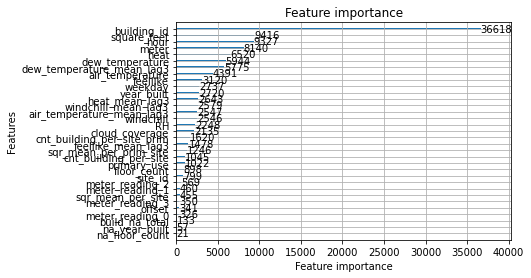

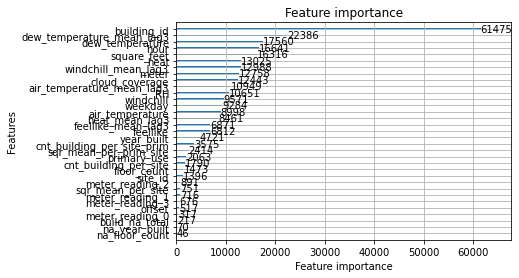

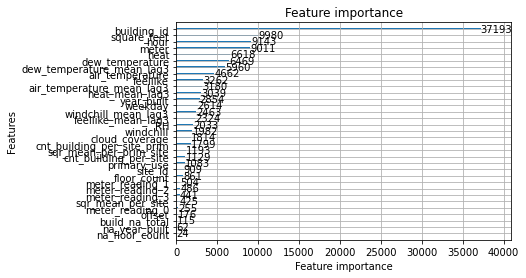

In [83]:
# %matplotlib inline
for model in models:
    lgb.plot_importance(model)
    plt.show()

In [84]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = features.columns.values
df_fimp_1["importance"] = model.feature_importance(importance_type='gain')
df_fimp_1["half"] = 1

In [85]:
df_fimp_1.sort_values(by='importance')

,feature,importance,half
8,na_floor_count,7.029058e+04,1
7,na_year_built,8.189469e+04,1
9,build_na_total,1.521129e+05,1
19,cloud_coverage,4.240755e+05,1
22,RH,4.935658e+05,1
10,meter_reading_0,6.120690e+05,1
21,offset,6.192849e+05,1
16,sqr_mean_per_site,9.461149e+05,1
29,windchill_mean_lag3,1.066206e+06,1
11,meter_reading_1,1.168751e+06,1


## Load Test Data

In [94]:
test_df = pd.read_csv('test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
#test_df = reduce_mem_usage(test_df)

## Merge Building Data

In [95]:
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

329

## Fill Weather Information

In [96]:
weather_df = pd.read_csv('weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



add heat, RH...
add lag features
Memory usage of dataframe is 32.61 MB
Memory usage after optimization is: 19.78 MB
Decreased by 39.3%


## Merge Weather Data

In [97]:
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
#test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].astype('float'))

test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

364

## Features Engineering

In [98]:
test_df = features_engineering(test_df)

## Prediction

In [99]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
del test_df, models
gc.collect()

7

## Submission

In [101]:
results_df = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()


0

In [102]:
results_df.head()

,row_id,meter_reading
0,0,148.754866
1,1,68.503427
2,2,9.744331
3,3,249.953298
4,4,1407.876299


In [103]:
results_df.to_csv('submission_withoutleak001.csv.gz',index=False,compression='gzip', float_format='%.4f', chunksize=25000)


In [104]:
#!kaggle competitions submit -c ashrae-energy-prediction -f submission_withoutleak001.csv.gz -m "submission_withoutleak001.csv"